In [1]:
from contrastive import CPCA
from copy import copy
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from pyensembl import ensembl_grch38
from rpca import R_pca
import scipy
from scipy.linalg import svd
from sklearn.decomposition import PCA, SparsePCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import label_binarize
from supervisedPCA import supervised_pca
import time

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Utility functions.
def to_one_hot_one_feature(U):
    """ Assumes U has a single feature.
    Returns matrix of size U.shape[0], number_unique + 1
    """
    as_set = set(U)
    print(as_set)
    set_as_list = list(as_set)
    one_hot = np.zeros((U.shape[0], len(as_set)))
    for i in range(U.shape[0]):
        one_hot[i, set_as_list.index(U[i])] = 1
    return one_hot

def load_data(data_dir, split_by):
    fg_data = np.load("{}cases.npy".format(data_dir))
    bg_data = np.load("{}controls.npy".format(data_dir))
    matches = np.load("{}matches.npy".format(data_dir))
    try:
        stages  = np.load("{}cases_stages.npy".format(data_dir))
    except FileNotFoundError:
        stages = np.array([])
    if split_by == "Stage":
        bg_data = np.squeeze(fg_data[np.where(stages == "stage iv"), :])
        fg_data = np.squeeze(fg_data[np.where(stages == "stage i"), :])
        print(bg_data.shape)
        print(fg_data.shape)
        matches = []
        fname_base = "stage"
    return fg_data, bg_data, matches, stages

In [15]:
plt.rcParams['savefig.dpi'] = 300
cancer_type = "Combined"
split_by = "Case_Control"

test_case_control = False
test_tissue_type = True

if test_tissue_type:
    fname_base = "tissue_type"
elif test_case_control:
    fname_base = "case_control"
else:
    fname_base = "stage"

plot_clusters = True
calc_onc_selection = True
plot_selection = (True and calc_onc_selection)
write_enrichment = True
plot_singular_values = False

add_unmatched = cancer_type in ["GBM", "Combined"] # only add unmatched for GBM/combined due to lack of matched samples
pct_train = 0.6
split_in_order = False

In [16]:
fg_data_brca, bg_data_brca, matches_brca, stages_brca = load_data("BRCA/", split_by)
fg_data_luad, bg_data_luad, matches_luad, stages_luad = load_data("LUAD/", split_by)
fg_data_gbm, bg_data_gbm, matches_gbm, stages_gbm = load_data("GBM/", split_by)
foreground_data = np.vstack((fg_data_brca, fg_data_luad, fg_data_gbm))
background_data = np.vstack((bg_data_brca, bg_data_luad, bg_data_gbm))
matches_luad[:, 0] += len(bg_data_brca)
matches_luad[:, 1] += len(fg_data_brca)
if len(matches_gbm > 0):
    matches_gbm[:, 0] += len(bg_data_brca) + len(bg_data_luad)
    matches_gbm[:, 1] += len(fg_data_brca) + len(fg_data_luad)
    matches = np.vstack((matches_brca, matches_luad, matches_gbm))
else:
    matches = np.vstack((matches_brca, matches_luad))
cancer_types_fg = np.zeros((foreground_data.shape[0], 3))
cancer_types_fg[:fg_data_brca.shape[0], 0] = 1
cancer_types_fg[fg_data_brca.shape[0]:fg_data_brca.shape[0]+fg_data_luad.shape[0], 1] = 1
cancer_types_fg[fg_data_brca.shape[0]+fg_data_luad.shape[0]:, 2] = 1

print(stages_brca.shape)
print(stages_luad.shape)
print(stages_gbm.shape)
stages = np.vstack((np.expand_dims(stages_brca, 1), np.expand_dims(stages_luad, 1), np.expand_dims(stages_gbm, 1)))

n_fg = len(foreground_data)
n_bg = len(background_data)
transcript_names = np.load("transcript_names.npy")
print(n_fg, n_bg, len(transcript_names))

(1102,)
(533,)
(312,)
1947 182 60483


In [17]:
# Convert transcript names into gene names.
transcript_names_converted = []
class Nil(object):
    pass
not_found = Nil()
not_found.gene_name = "Not Found"
for i, t_id in enumerate(transcript_names):
    try:
        transcript_names_converted.append(ensembl_grch38.gene_by_id(t_id[2:-3]))
    except ValueError:
        transcript_names_converted.append(not_found)
        foreground_data[:, i] = 0.
        background_data[:, i] = 0.
transcript_names = np.array(transcript_names_converted)

In [18]:
# Organize data.
fg_mask = np.std(foreground_data, axis=0) > 1e-1
bg_mask = np.std(background_data, axis=0) > 1e-1
mask = np.logical_and(fg_mask, bg_mask)
name_mask = np.array([x != not_found for x in transcript_names])
mask = np.logical_and(mask, name_mask)
foreground_data = foreground_data[:, mask]
background_data = background_data[:, mask]
transcript_names = transcript_names[mask]
n_transcripts = 50000
foreground_data = foreground_data[:, :n_transcripts]
background_data = background_data[:, :n_transcripts]
transcript_names = transcript_names[:n_transcripts]
print(foreground_data.shape)
print(background_data.shape)

from sklearn.preprocessing import normalize
combined = np.vstack((foreground_data, background_data))
combined_normed = normalize(combined, axis=1)
combined_normed = normalize(combined_normed, axis=0)
del combined
foreground_data = combined_normed[:n_fg]
background_data = combined_normed[n_fg:]

if split_in_order:
    n_train_fg = int(pct_train*n_fg)
    n_train_bg = int(pct_train*n_bg)
    n_train_fg = len(fg_data_brca)
    n_train_bg = len(bg_data_brca)
    train_fg_idxs = np.array(range(n_train_fg))
    train_bg_idxs = np.array(range(n_train_bg))
    test_fg_idxs  = np.array(range(n_train_fg, n_fg))
    test_bg_idxs  = np.array(range(n_train_bg, n_bg))
    n_test_fg = len(test_fg_idxs)
    n_test_bg = len(test_bg_idxs)
else:
    train_fg_idxs, test_fg_idxs = train_test_split(list(range(n_fg)), test_size=1-pct_train)
    train_bg_idxs, test_bg_idxs = train_test_split(list(range(n_bg)), test_size=1-pct_train)
    n_train_fg = len(train_fg_idxs)
    n_test_fg  = len(test_fg_idxs)
    n_train_bg = len(train_bg_idxs)
    n_test_bg  = len(test_bg_idxs)

(1947, 31831)
(182, 31831)


In [19]:
max_n_components = 25
train_fg = foreground_data[train_fg_idxs]
train_bg = background_data[train_bg_idxs]
test_fg  = foreground_data[test_fg_idxs]
test_bg  = background_data[test_bg_idxs]
train_data = np.vstack((train_fg, train_bg))
test_data  = np.vstack((test_fg,  test_bg))
train_labels = np.ravel(np.vstack((np.ones((n_train_fg, 1)), np.zeros((n_train_bg, 1)))))
test_labels = np.ravel(np.vstack((np.ones((n_test_fg, 1)), np.zeros((n_test_bg, 1)))))

In [20]:
# Make differential dataset
differential = np.zeros((1, foreground_data.shape[1]))
if len(matches) > 0:
    print("****Matched****")
    differential = np.array([foreground_data[i] - background_data[j] for [j, i] in matches if i in train_fg_idxs and j in train_bg_idxs])
    differential = np.vstack((differential, np.zeros_like(differential)))
if add_unmatched:
    n_differential = 750
    print("****Adding {} unmatched differences****".format(n_differential))
    unmatched = np.array([foreground_data[np.random.choice(train_fg_idxs)] - background_data[np.random.choice(train_bg_idxs)] for _ in range(n_differential)])
    unmatched = np.vstack((unmatched, np.zeros_like(unmatched)))
    differential = np.vstack((differential, unmatched))

differential = normalize(differential, axis=1)
differential = normalize(differential, axis=0)

****Matched****
****Adding 750 unmatched differences****


In [21]:
if cancer_type == "Combined":
    train_cancer_types = cancer_types_fg[train_fg_idxs]
    test_cancer_types  = cancer_types_fg[test_fg_idxs]

if not test_case_control and not test_tissue_type:
    stages_parsed = np.zeros((len(stages), 5))
    for i, stage in enumerate(stages):
        stage = stage[0]
        if "stage iv" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 0, 0, 1])
        elif "stage iii" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 0, 1, 0])
        elif "stage ii" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 1, 0, 0])
        elif "stage i" in stage.lower():
            stages_parsed[i, :] = np.array([0, 1, 0, 0, 0])
        else:
            stages_parsed[i, :] = np.array([1, 0, 0, 0, 0])

    stages = stages_parsed
    train_stages = stages[train_fg_idxs]
    test_stages  = stages[test_fg_idxs]
    train_stages = np.argmax(train_stages, axis=1)
    test_stages = np.argmax(test_stages, axis=1)
    print(train_stages.shape)
    print(test_stages.shape)

def get_differential(data, numComponents=None):
        m, n = data.shape
        data -= data.mean(axis=0)

        pca = PCA(n_components=numComponents)
        data_components = pca.fit_transform(data)
        return data_components, pca.singular_values_, pca.components_.T
        """
        print("Calculating cov")
        R = np.cov(data, rowvar=False)
        print("Finished cov")
        # use 'eigh' rather than 'eig' since R is symmetric,
        # the performance gain is substantial
        evals, evecs = np.linalg.eigh(R)
        print("Finished eigh.")
        idx = np.argsort(evals)[::-1]
        evecs = evecs[:,idx]
        evals = evals[idx]
        if numComponents is not None:
            evecs = evecs[:, :numComponents]
        # carry out the transformation on the data using eigenvectors
        # and return the re-scaled data, eigenvalues, and eigenvectors
        return np.dot(evecs.T, data.T).T, evals, evecs
        """

In [22]:
# Fit All Dim Reduction Methods.

# Normal PCA
print("Fitting PCA...", end='')
t = time.time()
pca = PCA(n_components=max_n_components)
pca_train_reduced = pca.fit_transform(train_data)
print("Took {:.3f} seconds".format(time.time() - t))
pca_test_reduced = pca.transform(test_data)
pca_components = pca.components_
pca_sing = pca.singular_values_


print("Fitting ICA...", end='')
t = time.time()
ica = FastICA(n_components=max_n_components)
ica_train_reduced = ica.fit_transform(train_data)
print("Took {:.3f} seconds".format(time.time() - t))
ica_test_reduced  = ica.transform(test_data)
ica_components    = ica.components_.copy()

print("Fitting CCA...", end='')
import sys
t = time.time()
from sklearn.cross_decomposition import CCA
ccas = []
cca_train_reduced = np.zeros((train_data.shape[0], max_n_components))
cca_components    = np.zeros((max_n_components, train_data.shape[1]))
cur_reps_cca      = np.zeros_like(train_data)
for i in range(max_n_components):
    sys.stdout.flush()
    print(i, end='')
    cca = CCA(n_components=1, scale=True)
    data_to_reduce = train_data-cur_reps_cca
    if data_to_reduce.shape[1] > 50:
        pca_cca = PCA(n_components=50)
        data_to_reduce = pca_cca.fit_transform(data_to_reduce)
    cca.fit(data_to_reduce, train_labels)
    cca_components[i, :] = np.squeeze(cca.x_weights_.T.dot(pca_cca.components_))
    cca_train_reduced[:, i] = np.squeeze(train_data.dot(np.expand_dims(cca_components[i, :], 1)))
    cur_reps_cca += np.expand_dims(cca_train_reduced[:, i], 1).dot(np.expand_dims(cca_components[i, :], 1).T)
    ccas.append(copy(cca))
print("Took {:.3f} seconds".format(time.time() - t))
cca_test_reduced  = np.array([np.squeeze(test_data.dot(np.expand_dims(cca_components[i, :], 1))) for i in range(max_n_components)]).T

print("Fitting LDA...", end='')
t = time.time()
ldas = []
pca_ldas = []
lda_train_reduced = np.zeros((train_data.shape[0], max_n_components))
lda_components    = np.zeros((max_n_components, train_data.shape[1]))
cur_reps_lda      = np.zeros_like(train_data)
for i in range(max_n_components):
    sys.stdout.flush()
    print(i, end='')
    lda = LDA(n_components=1)
    data_to_reduce = train_data-cur_reps_lda
    if data_to_reduce.shape[1] > 100:
        pca_lda = PCA(n_components=100)
        data_to_reduce = pca_lda.fit_transform(data_to_reduce)
        pca_ldas.append(pca_lda)
    lda_train_reduced[:, i] = np.squeeze(lda.fit_transform(data_to_reduce, train_labels))
    lda_components[i, :]    = lda.scalings_.T.dot(pca_lda.components_)
    cur_reps_lda += np.expand_dims(lda_train_reduced[:, i], 1).dot(np.expand_dims(lda_components[i, :], 1).T)
    ldas.append(copy(lda))
print("Took {:.3f} seconds".format(time.time() - t))
lda_test_reduced  = np.zeros((test_data.shape[0], max_n_components))
cur_reps = np.zeros_like(test_data)
for i in range(max_n_components):
    lda_test_reduced[:, i] = np.squeeze(ldas[i].transform(pca_ldas[i].transform(test_data - cur_reps)))
    cur_reps += np.expand_dims(lda_test_reduced[:, i], 1).dot(np.expand_dims(lda_components[i, :], 1).T)

print("Fitting SupPCA...", end='')
t = time.time()
sup_pca = supervised_pca.SupervisedPCAClassifier(n_components=max_n_components)
sup_pca.fit(train_data, train_labels)
sup_train_reduced = sup_pca.get_transformed_data(train_data)
sup_test_reduced  = sup_pca.get_transformed_data(test_data)
sup_components    = sup_pca.get_components()
print("Took {:.3f} seconds".format(time.time() - t))

print("Fitting PLS...", end='')
t = time.time()
plsr = PLSRegression(n_components=max_n_components, scale=True)
plsr.fit(train_data, train_labels)
plsr_train_reduced = plsr.x_scores_
plsr_test_reduced  = plsr.transform(test_data)
plsr_components    = plsr.x_weights_.T # n_components x n_features
print("Took {:.3f} seconds".format(time.time() - t))

# Contrastive PCA
print("Fitting cPCA...", end='')
t = time.time()
mdl = CPCA(n_components=max_n_components)
cpca_preprocess = PCA(n_components=500)
train_data_preprocessed = cpca_preprocess.fit_transform(train_data)
test_data_preprocessed = cpca_preprocess.transform(test_data)
cpca_preprocess_components = cpca_preprocess.components_.copy()
cpca_train_fg_reduced, alpha = mdl.fit_transform(train_data_preprocessed[:n_train_fg], train_data_preprocessed[n_train_fg:],
    n_alphas=1, n_alphas_to_return=1, return_alphas=True)
alpha = alpha[0]
print("Took {:.3f} seconds".format(time.time() - t))
cpca_train_fg_reduced = cpca_train_fg_reduced[0]
cpca_train_bg_reduced = mdl.transform(train_data_preprocessed[n_train_fg:])[0]
cpca_train_reduced = np.vstack((cpca_train_fg_reduced, cpca_train_bg_reduced))
cpca_test_reduced = mdl.transform(test_data_preprocessed)[0]
pca = PCA(n_components=max_n_components)
pca.fit(mdl.fg_cov - alpha*mdl.bg_cov)
cpca_components = pca.components_.dot(cpca_preprocess_components)

print("Fitting rPCA...", end='')
t = time.time()
rpca = R_pca(train_data)
L, S = rpca.fit(max_iter=5000, iter_print=100)
_, rpca_evals, rpca_evecs = get_differential(L, max_n_components)
rpca_components = rpca_evecs.T
rpca_train_reduced = train_data.dot(rpca_evecs)
rpca_test_reduced  = test_data.dot(rpca_evecs)
print("Took {:.3f} seconds.".format(time.time() - t))

print("Fitting dPCA...", end='')
t = time.time()
dpca = PCA(n_components=max_n_components)
dpca.fit(differential)
print("Took {:.3f} seconds.".format(time.time() - t))
dpca_train_reduced = dpca.transform(train_data)
dpca_test_reduced  = dpca.transform(test_data)
dpca_components = dpca.components_.copy()
diff_sing = dpca.singular_values_.copy()


print("Fitting dsPCA...", end='')
t = time.time()
drpca_pca = PCA(n_components=100)
differential_pca = drpca_pca.fit_transform(differential)
dspca = SparsePCA(n_components=max_n_components, max_iter=10,
    verbose=False, alpha=10, ridge_alpha=0.01)
dspca.fit(differential_pca)
dspca_components = dspca.components_.dot(drpca_pca.components_)
dspca_train_reduced = train_data.dot(dspca_components.T)
dspca_test_reduced  = test_data.dot(dspca_components.T)
print("Took {:.3f} seconds.".format(time.time() - t))


# drPCA
print("Fitting drPCA...", end='')
t = time.time()
rpca = R_pca(differential_pca)
L, S = rpca.fit(max_iter=5000, iter_print=100)
print(L)
_, drpca_evals, drpca_evecs = get_differential(L, max_n_components)
drpca_components = drpca_evecs.T.dot(drpca_pca.components_)
drpca_train_reduced = train_data.dot(drpca_components.T)
drpca_test_reduced  = test_data.dot(drpca_components.T)
print("Took {:.3f} seconds.".format(time.time() - t))

reduced = [(pca_train_reduced, pca_test_reduced, pca_components, "PCA"),
    (rpca_train_reduced, rpca_test_reduced, rpca_components, "rPCA"),
    (ica_train_reduced, ica_test_reduced, ica_components, "ICA"),
    (cpca_train_reduced, cpca_test_reduced, cpca_components,  "cPCA"),
    (sup_train_reduced, sup_test_reduced, sup_components, "Sup. PCA"),
    (cca_train_reduced, cca_test_reduced, cca_components, "CCA"),
    (plsr_train_reduced, plsr_test_reduced, plsr_components, "PLS-DA"),
    (lda_train_reduced, lda_test_reduced, lda_components, "LDA"),
    (dpca_train_reduced, dpca_test_reduced, dpca_components, "dPCA"),
    (drpca_train_reduced, drpca_test_reduced, drpca_components, "drPCA")
    ]

Fitting PCA...Took 2.681 seconds
Fitting ICA...Took 9.744 seconds
Fitting CCA...0123456789101112131415161718192021222324Took 110.190 seconds
Fitting LDA...0123456789101112131415161718192021222324Took 132.738 seconds
Fitting SupPCA...Took 40.598 seconds
Fitting PLS...Took 11.158 seconds
Fitting cPCA...Took 14.122 seconds
Fitting rPCA...iteration: 1, error: 0.0008598522944184188
Took 34.010 seconds.
Fitting dPCA...Took 3.385 seconds.
Fitting dsPCA...Took 5.777 seconds.
Fitting drPCA...iteration: 1, error: 6.486317769401083
iteration: 3, error: 0.001177060682028993
[[ 1.21551328e+00 -1.14015131e+00 -3.06307858e-01 ...  2.42186897e-01
   2.13376108e-01  7.36747298e-02]
 [ 1.06981708e+00 -3.54313498e-02 -1.61025029e+00 ...  5.95579282e-02
  -3.53577558e-01  3.18852391e-01]
 [-9.84746965e-01  3.29436764e-01  2.39603523e-01 ...  2.45647917e-01
   3.12643378e-01  4.80766161e-01]
 ...
 [-3.25076783e-01 -2.46642013e-01  4.13938511e-01 ...  3.21583350e-03
  -2.46743692e-03 -6.50378013e-04]
 [-3.2

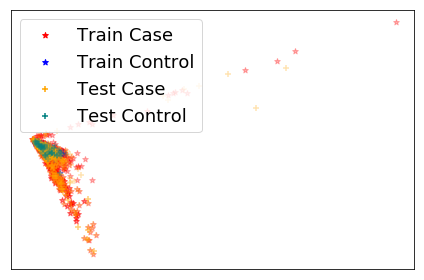

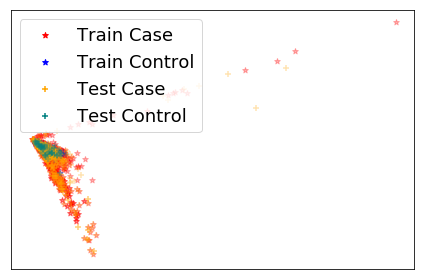

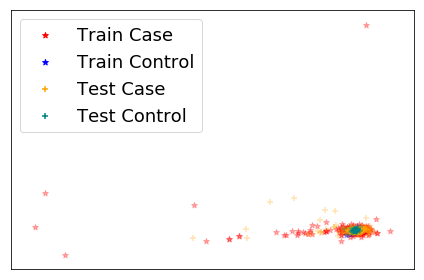

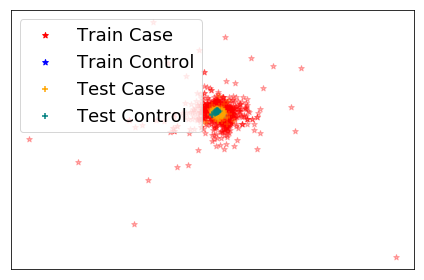

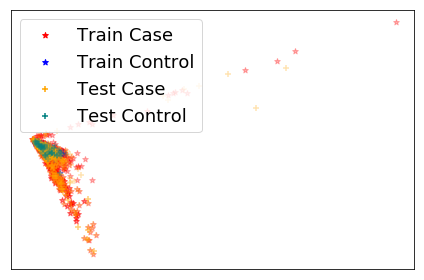

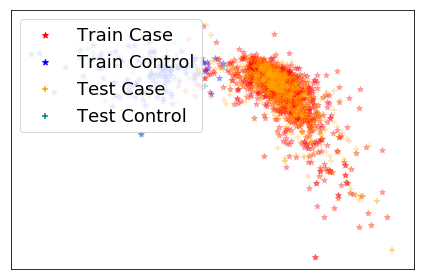

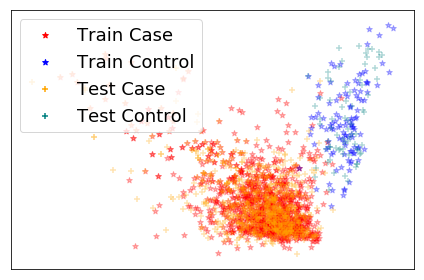

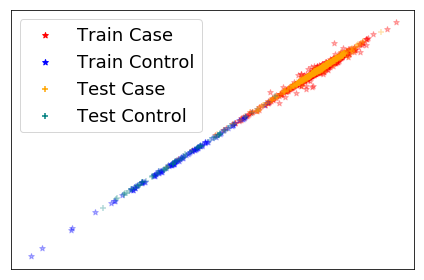

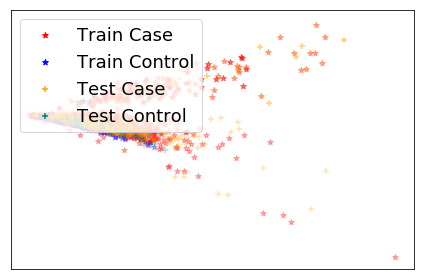

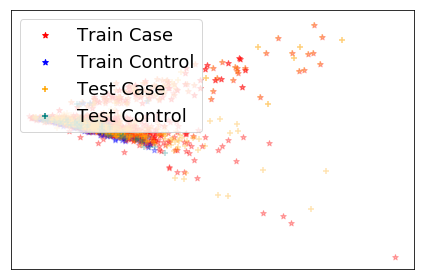

In [23]:
def plot_clusts(fg_train, bg_train, fg_test, bg_test, name):
    fig = plt.figure()
    plt.scatter(fg_train[:, 0], fg_train[:, 1], marker='*', color='red', label='Train Case', alpha=0.3)
    plt.scatter(bg_train[:, 0], bg_train[:, 1], marker='*', color='blue', label='Train Control', alpha=0.3)
    plt.scatter(fg_test[:, 0], fg_test[:, 1], marker='+', color='orange', label='Test Case', alpha=0.3)
    plt.scatter(bg_test[:, 0], bg_test[:, 1], marker='+', color='teal', label='Test Control', alpha=0.3)
    points = np.vstack((fg_test, bg_test))
    #plt.annotate("Test Sil: {:.3f}".format(silhouette_score(points, test_labels)),
    #    (np.min(points[:, 0]), np.max(points[:, 1])))
    plt.xticks([])
    plt.yticks([])
    lgd = plt.legend(fontsize=18, loc='upper left')
    for lh in lgd.legendHandles:
        lh.set_alpha(1.0)
    plt.tight_layout()
    plt.savefig("{}/Results/Clusters/{}_{}.png".format(cancer_type, fname_base, name))

if plot_clusters:
    helper = lambda train, test, name: plot_clusts(train[:n_train_fg, :2], train[n_train_fg:, :2],
                                            test[:n_fg-n_train_fg, :2], test[n_fg-n_train_fg:, :2], name)
    for (train, test, components, name) in reduced:
        helper(train, test, name)

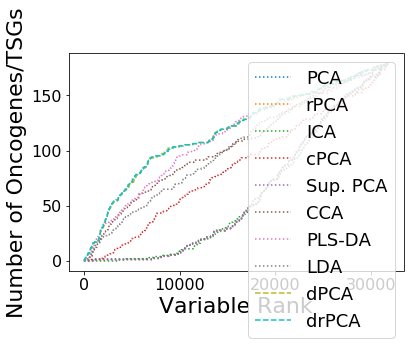

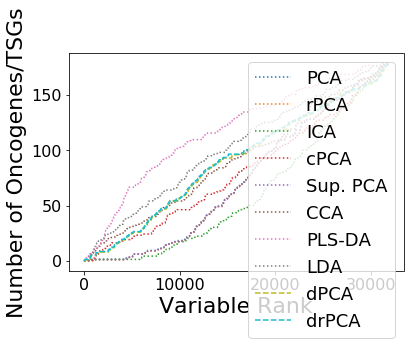

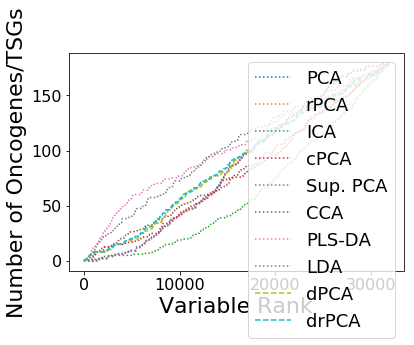

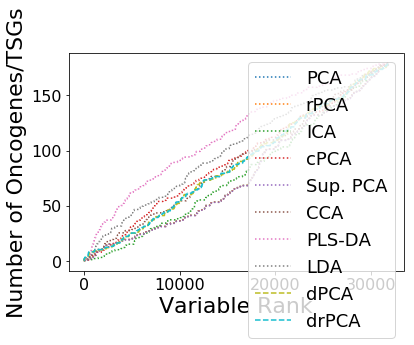

In [24]:
# Plot the Rank Curve
cosmic_genes = set([])
with open("cosmic_gene_census.tsv", 'r') as gene_census:
    for line in gene_census:
        cosmic_genes.add(line.split('\t')[0].upper())

def generate_curve(sorted_list):
    counts = []
    count = 0
    for (i, val) in sorted_list:
        if transcript_names[i].gene_name.upper() in cosmic_genes:
            count += 1
        counts.append(count)
    return counts

def plot_list_top(n):
    sort_helper = lambda components: [i for i in sorted(enumerate(np.sum(components[:n], axis=0)), key=lambda x: np.abs(x[1]), reverse=True)]
    sorted_components = [sort_helper(components) for (train, test, components, name) in reduced]

    def write_to_file(sorted_components, name):
        os.makedirs("{}/Results/Components/{}".format(cancer_type, name), exist_ok=True)
        with open("{}/Results/Components/{}/{}_{}_top_{}.csv".format(cancer_type, name, fname_base, name, n), 'w') as csv_file:
            with open("{}/Results/Components/{}/{}_{}_top_{}.tsv".format(cancer_type, name, fname_base, name, n), 'w') as tsv_file:
                for (idx, magnitude) in sorted_components:
                    print("{},{}".format(transcript_names[idx].gene_name, magnitude), file=csv_file)
                    print("{}\t{}".format(transcript_names[idx].gene_name, magnitude), file=tsv_file)

    if write_enrichment:
        for i, comps in enumerate(sorted_components):
            write_to_file(comps, reduced[i][-1])

    if plot_selection:
        fig = plt.figure()
        helper = lambda counts, name, linestyle: plt.plot(counts, label=name, linestyle=linestyle)
        for i, comps in enumerate(sorted_components):
            name = reduced[i][-1]
            if name == "drPCA" or name == "dsPCA" or name == "dPCA" or name == "dICA":
                helper(np.array(generate_curve(comps)) + np.random.uniform(0, 1), name, 'dashed')
            else:
                helper(np.array(generate_curve(comps)) + np.random.uniform(0, 1), name, 'dotted')
        plt.xlabel("Variable Rank", fontsize=22)
        plt.ylabel("Number of Oncogenes/TSGs", fontsize=22)
        ax = plt.gca()
        ax.tick_params(labelsize=16)
        plt.legend(fontsize=18)
        plt.savefig("{}/Results/oncogene_selection_top_{}_{}".format(cancer_type, n, fname_base))
    return sorted_components

if calc_onc_selection:
    sorted_components = plot_list_top(1)
    plot_list_top(2)
    plot_list_top(3)
    plot_list_top(5)

In [25]:
from sklearn.model_selection import RandomizedSearchCV
def calc_predictive(n_components=5):
    helper = lambda reps, labels, name: print("{}: {:.3f}".format(name,
        silhouette_score(reps[:, :n_components], labels)))
    print("="*20)
    print("Silhouette Scores, Training Data:")
    for (train, test, comps, name) in reduced:
        helper(train, train_labels, name)
    
    print('-'*20)
    print("Silhouette Scores, Testing Data:")
    for (train, test, comps, name) in reduced:
        helper(test, test_labels, name)
    print("="*20)

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start= 2, stop = 15, num = 3)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 20, num=5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    C_list = [0.01, 0.1, 0.5, 1., 2.5, 5.0, 10., 25.]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    lr_grid = {'C': C_list}
    def predict(x_train, x_test, y_train, y_test, calc_random):
        rf = RandomForestClassifier(n_estimators=3)
        clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
            n_iter=8, cv=2, verbose=0)

        clf.fit(x_train, y_train)
        #cross_validate(clf, x_train, y_train, return_train_score=False)

        if not test_tissue_type and not test_case_control:
            binarize = lambda x: label_binarize(x, classes=[0, 1, 2, 3, 4])
            auc_train = np.mean([roc_auc_score(binarize(y_train)[:, i], binarize(clf.predict(x_train))[:, i]) for i in range(5)])
            auc = np.mean([roc_auc_score(binarize(y_test)[:, i], binarize(clf.predict(x_test))[:, i]) for i in range(5)])
        else:
            auc_train = roc_auc_score(y_train, clf.predict(x_train), average='micro')
            auc = roc_auc_score(y_test, clf.predict(x_test))
        acc = accuracy_score(y_test, clf.predict(x_test))

        if calc_random:
            random_preds = np.ones_like(y_test)
            acc_random = 0.5 #accuracy_score(y_test, random_preds)
            auc_random = 0.5 #roc_auc_score(y_test, random_preds)
            return acc, auc, auc_train, acc_random, auc_random
        else:
            return acc, auc, auc_train

    if test_tissue_type:
        helper  = lambda train, test: predict(train[:n_train_fg, :n_components], test[:n_test_fg, :n_components], train_cancer_types, test_cancer_types, True)
    elif test_case_control:
        helper  = lambda train, test: predict(train[:, :n_components], test[:, :n_components], train_labels, test_labels, True)
    else:
        helper  = lambda train, test: predict(train[:n_train_fg, :n_components], test[:n_test_fg, :n_components], train_stages, test_stages, True)

    accs = []
    aucs = []
    aucs_train = []
    for (train_reduced, test_reduced, comps, name) in reduced:
        my_accs, my_auc, my_auc_train, accs_random, auc_random = helper(train_reduced, test_reduced)
        accs.append(my_accs)
        aucs.append(my_auc)
        aucs_train.append(my_auc_train)

    print("="*20)
    print("Case/Control AUC, Training Data")
    helper = lambda name, auc: print("{}: {:.3f}".format(name, auc))
    for i, auc_train in enumerate(aucs_train):
        helper(reduced[i][-1], auc_train)

    print("-"*20)
    print("Case/Control AUC, Testing Data")
    for i, auc in enumerate(aucs):
        helper(reduced[i][-1], auc)
    print("="*20)
    return aucs

N Components: 1
Silhouette Scores, Training Data:
PCA: -0.228
rPCA: -0.228
ICA: -0.383
cPCA: -0.383
Sup. PCA: -0.228
CCA: 0.751
PLS-DA: 0.505
LDA: 0.828
dPCA: -0.152
drPCA: -0.151
--------------------
Silhouette Scores, Testing Data:
PCA: -0.191
rPCA: -0.191
ICA: -0.302
cPCA: -0.084
Sup. PCA: -0.191
CCA: 0.761
PLS-DA: 0.500
LDA: 0.840
dPCA: -0.138
drPCA: -0.137
Case/Control AUC, Training Data
PCA: 0.768
rPCA: 0.756
ICA: 0.694
cPCA: 0.789
Sup. PCA: 0.733
CCA: 0.930
PLS-DA: 0.768
LDA: 0.672
dPCA: 0.715
drPCA: 0.735
--------------------
Case/Control AUC, Testing Data
PCA: 0.635
rPCA: 0.628
ICA: 0.558
cPCA: 0.508
Sup. PCA: 0.613
CCA: 0.622
PLS-DA: 0.588
LDA: 0.500
dPCA: 0.587
drPCA: 0.577
N Components: 2
Silhouette Scores, Training Data:
PCA: -0.275
rPCA: -0.275
ICA: -0.297
cPCA: -0.344
Sup. PCA: -0.275
CCA: 0.545
PLS-DA: 0.557
LDA: 0.828
dPCA: -0.171
drPCA: -0.171
--------------------
Silhouette Scores, Testing Data:
PCA: -0.266
rPCA: -0.266
ICA: -0.194
cPCA: -0.109
Sup. PCA: -0.266
CCA: 

drPCA: 0.063
--------------------
Silhouette Scores, Testing Data:
PCA: 0.014
rPCA: 0.014
ICA: -0.214
cPCA: -0.166
Sup. PCA: 0.014
CCA: 0.200
PLS-DA: 0.366
LDA: 0.839
dPCA: 0.098
drPCA: 0.098
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.947
cPCA: 0.995
Sup. PCA: 0.995
CCA: 0.982
PLS-DA: 0.981
LDA: 0.684
dPCA: 0.999
drPCA: 0.999
--------------------
Case/Control AUC, Testing Data
PCA: 0.991
rPCA: 0.993
ICA: 0.868
cPCA: 0.778
Sup. PCA: 0.986
CCA: 0.816
PLS-DA: 0.958
LDA: 0.513
dPCA: 0.976
drPCA: 0.984
N Components: 13
Silhouette Scores, Training Data:
PCA: -0.037
rPCA: -0.037
ICA: -0.247
cPCA: -0.294
Sup. PCA: -0.037
CCA: 0.151
PLS-DA: 0.369
LDA: 0.827
dPCA: 0.066
drPCA: 0.066
--------------------
Silhouette Scores, Testing Data:
PCA: 0.015
rPCA: 0.015
ICA: -0.204
cPCA: -0.166
Sup. PCA: 0.015
CCA: 0.197
PLS-DA: 0.363
LDA: 0.839
dPCA: 0.098
drPCA: 0.098
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.999
ICA: 0.994
cPCA: 0.986
Sup. PCA: 1.000
CCA: 0.972
PLS-DA: 1.000
L

dPCA: 0.076
drPCA: 0.075
--------------------
Silhouette Scores, Testing Data:
PCA: 0.073
rPCA: 0.073
ICA: 0.161
cPCA: -0.139
Sup. PCA: 0.073
CCA: 0.190
PLS-DA: 0.346
LDA: 0.839
dPCA: 0.105
drPCA: 0.105
Case/Control AUC, Training Data
PCA: 0.991
rPCA: 0.998
ICA: 1.000
cPCA: 0.998
Sup. PCA: 1.000
CCA: 0.987
PLS-DA: 0.993
LDA: 0.714
dPCA: 0.996
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.978
rPCA: 0.988
ICA: 0.949
cPCA: 0.771
Sup. PCA: 0.985
CCA: 0.817
PLS-DA: 0.953
LDA: 0.518
dPCA: 0.975
drPCA: 0.988
N Components: 24
Silhouette Scores, Training Data:
PCA: 0.003
rPCA: 0.003
ICA: 0.148
cPCA: -0.284
Sup. PCA: 0.003
CCA: 0.116
PLS-DA: 0.352
LDA: 0.827
dPCA: 0.076
drPCA: 0.075
--------------------
Silhouette Scores, Testing Data:
PCA: 0.073
rPCA: 0.072
ICA: 0.259
cPCA: -0.139
Sup. PCA: 0.073
CCA: 0.193
PLS-DA: 0.344
LDA: 0.839
dPCA: 0.104
drPCA: 0.104
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.999
ICA: 0.990
cPCA: 1.000
Sup. PCA: 0.999
CCA: 1.000
PLS-DA: 0

PCA: 0.008
rPCA: 0.008
ICA: -0.209
cPCA: -0.167
Sup. PCA: 0.008
CCA: 0.190
PLS-DA: 0.376
LDA: 0.839
dPCA: 0.105
drPCA: 0.106
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.991
cPCA: 0.984
Sup. PCA: 1.000
CCA: 0.979
PLS-DA: 1.000
LDA: 0.829
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.993
rPCA: 0.993
ICA: 0.906
cPCA: 0.751
Sup. PCA: 0.990
CCA: 0.806
PLS-DA: 0.979
LDA: 0.560
dPCA: 0.986
drPCA: 0.973
N Components: 11
Silhouette Scores, Training Data:
PCA: -0.036
rPCA: -0.037
ICA: -0.256
cPCA: -0.297
Sup. PCA: -0.037
CCA: 0.158
PLS-DA: 0.378
LDA: 0.827
dPCA: 0.063
drPCA: 0.063
--------------------
Silhouette Scores, Testing Data:
PCA: 0.012
rPCA: 0.012
ICA: -0.209
cPCA: -0.169
Sup. PCA: 0.012
CCA: 0.197
PLS-DA: 0.372
LDA: 0.839
dPCA: 0.098
drPCA: 0.098
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.996
cPCA: 0.997
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 0.699
dPCA: 1.000
drPCA: 0.999
--------------------
Case/Contro

drPCA: 0.074
--------------------
Silhouette Scores, Testing Data:
PCA: 0.069
rPCA: 0.069
ICA: 0.176
cPCA: -0.152
Sup. PCA: 0.069
CCA: 0.192
PLS-DA: 0.350
LDA: 0.839
dPCA: 0.106
drPCA: 0.104
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.985
cPCA: 0.998
Sup. PCA: 0.999
CCA: 1.000
PLS-DA: 1.000
LDA: 0.719
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.989
rPCA: 0.986
ICA: 0.949
cPCA: 0.755
Sup. PCA: 0.991
CCA: 0.845
PLS-DA: 0.972
LDA: 0.530
dPCA: 0.986
drPCA: 0.986
N Components: 22
Silhouette Scores, Training Data:
PCA: 0.006
rPCA: 0.006
ICA: 0.004
cPCA: -0.285
Sup. PCA: 0.006
CCA: 0.120
PLS-DA: 0.355
LDA: 0.827
dPCA: 0.075
drPCA: 0.074
--------------------
Silhouette Scores, Testing Data:
PCA: 0.073
rPCA: 0.073
ICA: 0.162
cPCA: -0.141
Sup. PCA: 0.073
CCA: 0.190
PLS-DA: 0.348
LDA: 0.839
dPCA: 0.105
drPCA: 0.105
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.981
cPCA: 0.966
Sup. PCA: 0.997
CCA: 0.979
PLS-DA: 0.996
LDA: 0.

drPCA: 0.072
--------------------
Silhouette Scores, Testing Data:
PCA: 0.001
rPCA: 0.001
ICA: -0.209
cPCA: -0.170
Sup. PCA: 0.001
CCA: 0.200
PLS-DA: 0.402
LDA: 0.839
dPCA: 0.109
drPCA: 0.102
Case/Control AUC, Training Data
PCA: 0.998
rPCA: 0.998
ICA: 1.000
cPCA: 0.964
Sup. PCA: 1.000
CCA: 0.993
PLS-DA: 0.971
LDA: 0.699
dPCA: 1.000
drPCA: 0.992
--------------------
Case/Control AUC, Testing Data
PCA: 0.985
rPCA: 0.993
ICA: 0.840
cPCA: 0.726
Sup. PCA: 0.985
CCA: 0.810
PLS-DA: 0.879
LDA: 0.512
dPCA: 0.968
drPCA: 0.966
N Components: 9
Silhouette Scores, Training Data:
PCA: -0.045
rPCA: -0.045
ICA: -0.242
cPCA: -0.293
Sup. PCA: -0.045
CCA: 0.164
PLS-DA: 0.392
LDA: 0.827
dPCA: 0.073
drPCA: 0.073
--------------------
Silhouette Scores, Testing Data:
PCA: -0.003
rPCA: -0.003
ICA: -0.203
cPCA: -0.167
Sup. PCA: -0.003
CCA: 0.193
PLS-DA: 0.388
LDA: 0.839
dPCA: 0.110
drPCA: 0.110
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.969
cPCA: 1.000
Sup. PCA: 0.999
CCA: 0.997
PLS-DA: 0.996

PCA: 0.067
rPCA: 0.066
ICA: 0.213
cPCA: -0.153
Sup. PCA: 0.066
CCA: 0.193
PLS-DA: 0.352
LDA: 0.839
dPCA: 0.108
drPCA: 0.106
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.999
ICA: 0.982
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.971
PLS-DA: 1.000
LDA: 0.712
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.991
rPCA: 0.985
ICA: 0.913
cPCA: 0.760
Sup. PCA: 0.989
CCA: 0.816
PLS-DA: 0.979
LDA: 0.513
dPCA: 0.989
drPCA: 0.982
N Components: 20
Silhouette Scores, Training Data:
PCA: 0.005
rPCA: 0.005
ICA: 0.033
cPCA: -0.286
Sup. PCA: 0.005
CCA: 0.127
PLS-DA: 0.358
LDA: 0.827
dPCA: 0.075
drPCA: 0.075
--------------------
Silhouette Scores, Testing Data:
PCA: 0.069
rPCA: 0.068
ICA: 0.195
cPCA: -0.152
Sup. PCA: 0.069
CCA: 0.193
PLS-DA: 0.350
LDA: 0.839
dPCA: 0.106
drPCA: 0.106
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.995
ICA: 0.988
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 0.697
dPCA: 1.000
drPCA: 0.999
--------------------
Case/Control AUC,

--------------------
Silhouette Scores, Testing Data:
PCA: -0.036
rPCA: -0.036
ICA: -0.208
cPCA: -0.172
Sup. PCA: -0.036
CCA: 0.241
PLS-DA: 0.415
LDA: 0.839
dPCA: 0.129
drPCA: 0.126
Case/Control AUC, Training Data
PCA: 0.993
rPCA: 0.993
ICA: 0.981
cPCA: 0.966
Sup. PCA: 1.000
CCA: 0.953
PLS-DA: 0.924
LDA: 0.700
dPCA: 0.992
drPCA: 0.985
--------------------
Case/Control AUC, Testing Data
PCA: 0.979
rPCA: 0.982
ICA: 0.798
cPCA: 0.539
Sup. PCA: 0.983
CCA: 0.767
PLS-DA: 0.808
LDA: 0.514
dPCA: 0.976
drPCA: 0.975
N Components: 7
Silhouette Scores, Training Data:
PCA: -0.042
rPCA: -0.042
ICA: -0.244
cPCA: -0.308
Sup. PCA: -0.042
CCA: 0.202
PLS-DA: 0.411
LDA: 0.827
dPCA: 0.082
drPCA: 0.081
--------------------
Silhouette Scores, Testing Data:
PCA: -0.004
rPCA: -0.004
ICA: -0.211
cPCA: -0.169
Sup. PCA: -0.004
CCA: 0.224
PLS-DA: 0.406
LDA: 0.840
dPCA: 0.115
drPCA: 0.112
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.995
ICA: 0.985
cPCA: 1.000
Sup. PCA: 0.997
CCA: 0.957
PLS-DA: 0.918
LDA: 0.75

dPCA: 0.073
drPCA: 0.070
--------------------
Silhouette Scores, Testing Data:
PCA: 0.041
rPCA: 0.041
ICA: 0.228
cPCA: -0.158
Sup. PCA: 0.041
CCA: 0.193
PLS-DA: 0.354
LDA: 0.839
dPCA: 0.106
drPCA: 0.100
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.992
cPCA: 0.989
Sup. PCA: 1.000
CCA: 0.999
PLS-DA: 0.999
LDA: 0.941
dPCA: 0.980
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.991
rPCA: 0.990
ICA: 0.920
cPCA: 0.775
Sup. PCA: 0.991
CCA: 0.839
PLS-DA: 0.973
LDA: 0.634
dPCA: 0.962
drPCA: 0.986
N Components: 18
Silhouette Scores, Training Data:
PCA: -0.010
rPCA: -0.011
ICA: 0.058
cPCA: -0.287
Sup. PCA: -0.011
CCA: 0.132
PLS-DA: 0.360
LDA: 0.827
dPCA: 0.075
drPCA: 0.070
--------------------
Silhouette Scores, Testing Data:
PCA: 0.048
rPCA: 0.048
ICA: 0.213
cPCA: -0.154
Sup. PCA: 0.048
CCA: 0.193
PLS-DA: 0.354
LDA: 0.839
dPCA: 0.108
drPCA: 0.100
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.979
cPCA: 0.995
Sup. PCA: 0.999
CCA: 0.963
PLS-DA

drPCA: 0.035
--------------------
Silhouette Scores, Testing Data:
PCA: -0.146
rPCA: -0.146
ICA: -0.304
cPCA: -0.178
Sup. PCA: -0.146
CCA: 0.259
PLS-DA: 0.478
LDA: 0.840
dPCA: 0.055
drPCA: 0.064
Case/Control AUC, Training Data
PCA: 0.979
rPCA: 0.995
ICA: 0.786
cPCA: 0.998
Sup. PCA: 0.993
CCA: 0.884
PLS-DA: 0.960
LDA: 0.720
dPCA: 0.982
drPCA: 0.997
--------------------
Case/Control AUC, Testing Data
PCA: 0.976
rPCA: 0.979
ICA: 0.736
cPCA: 0.547
Sup. PCA: 0.983
CCA: 0.714
PLS-DA: 0.767
LDA: 0.534
dPCA: 0.970
drPCA: 0.974
N Components: 5
Silhouette Scores, Training Data:
PCA: -0.144
rPCA: -0.144
ICA: -0.308
cPCA: -0.304
Sup. PCA: -0.144
CCA: 0.239
PLS-DA: 0.448
LDA: 0.827
dPCA: 0.089
drPCA: 0.091
--------------------
Silhouette Scores, Testing Data:
PCA: -0.095
rPCA: -0.095
ICA: -0.285
cPCA: -0.170
Sup. PCA: -0.095
CCA: 0.250
PLS-DA: 0.443
LDA: 0.840
dPCA: 0.103
drPCA: 0.104
Case/Control AUC, Training Data
PCA: 0.999
rPCA: 0.990
ICA: 0.860
cPCA: 0.999
Sup. PCA: 0.998
CCA: 0.903
PLS-DA: 0.

drPCA: 0.069
--------------------
Silhouette Scores, Testing Data:
PCA: 0.043
rPCA: 0.043
ICA: 0.282
cPCA: -0.162
Sup. PCA: 0.043
CCA: 0.195
PLS-DA: 0.357
LDA: 0.839
dPCA: 0.101
drPCA: 0.100
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 0.984
Sup. PCA: 1.000
CCA: 0.996
PLS-DA: 0.996
LDA: 0.991
dPCA: 0.999
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.991
rPCA: 0.988
ICA: 0.921
cPCA: 0.764
Sup. PCA: 0.986
CCA: 0.824
PLS-DA: 0.968
LDA: 0.659
dPCA: 0.979
drPCA: 0.985
N Components: 16
Silhouette Scores, Training Data:
PCA: -0.015
rPCA: -0.015
ICA: 0.098
cPCA: -0.288
Sup. PCA: -0.015
CCA: 0.137
PLS-DA: 0.363
LDA: 0.827
dPCA: 0.070
drPCA: 0.069
--------------------
Silhouette Scores, Testing Data:
PCA: 0.041
rPCA: 0.041
ICA: 0.251
cPCA: -0.161
Sup. PCA: 0.041
CCA: 0.193
PLS-DA: 0.356
LDA: 0.839
dPCA: 0.102
drPCA: 0.100
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.999
cPCA: 0.976
Sup. PCA: 1.000
CCA: 0.994
PLS-DA: 1.000
LDA:

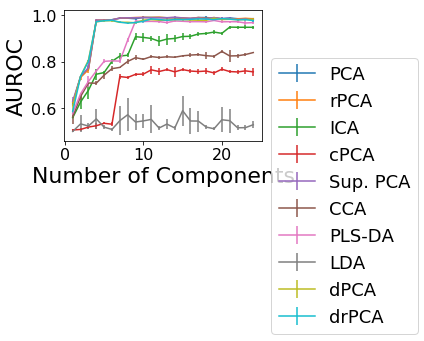

In [26]:
n_components_list = list(range(1, max_n_components))
n_iters = 5
n_methods = len(reduced)
results = np.zeros((n_methods, len(n_components_list), n_iters))
for n_iter in range(n_iters):
    for i, n_components in enumerate(n_components_list):
        print("N Components: {}".format(n_components))
        results[:, i, n_iter] = np.array(calc_predictive(n_components))

fig = plt.figure()
print("="*20)
print("Mean Case/Control AUC, Testing Data")
for i, (train, test, comps, name) in enumerate(reduced):
    if name == "Random":
        continue
    plt.errorbar(n_components_list, np.mean(results[i], axis=1), yerr=np.std(results[i], axis=1), label=name)
    print("{}:{:.3f}".format(name, np.mean(results[i])))
print("="*20)

plt.xlabel("Number of Components", fontsize=22)
plt.ylabel("AUROC", fontsize=22)
lgd = plt.legend(fontsize=18, bbox_to_anchor=(1, 0.7))
ax = plt.gca()
ax.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("{}/Results/aucroc_{}.png".format(cancer_type, fname_base), dpi=300,
    bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()